# Plot and explore the data

Make some plots and maps to see what the data look like.
For this, we'll use the combined dataset generated by [`merge.ipynb`](merge.ipynb).

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pygmt
import pooch
import verde as vd
import boule as bl

In [2]:
plt.rc("figure", dpi=120)
pygmt.config(FONT="11p,Helvetica,black")

/home/leo/miniconda3/envs/australia-gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the data

Download the data from the GitHub release using [Pooch](https://www.fatiando.org/pooch/latest/) and then read the netCDF file.
The download only happens once and is then cached by Pooch for later use in any other project.

In [3]:
fname = pooch.retrieve(
    url="https://github.com/compgeolab/australia-gravity-data/releases/download/v1.0/australia-ground-gravity.nc",
    known_hash="sha256:50f2fa53c5dc2c66dd3358b8e50024d21074fcc77c96191c549a10a37075bc7e",
    downloader=pooch.HTTPDownloader(progressbar=True)
)
data = xr.load_dataset("../australia-ground-gravity.nc")
data

/home/leo/miniconda3/envs/australia-gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|█████████████████████████████████████| 37.6M/37.6M [00:00<00:00, 34.9GB/s]
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/home/leo/miniconda3/envs/australia-gravity/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/home/leo/miniconda3/envs/australia-gravity/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:405: DeprecationWarning: tostring()

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

## Histograms

Look at the distribution of data values. This is helpful to make sure everything looks OK and we know the general trends in the data.

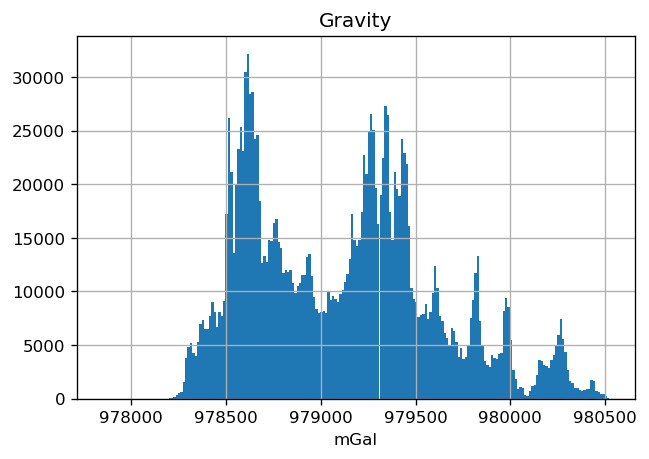

In [4]:
plt.figure()
plt.title("Gravity")
plt.hist(data.gravity.values, bins="auto")
plt.xlabel("mGal")
plt.grid()
plt.show()

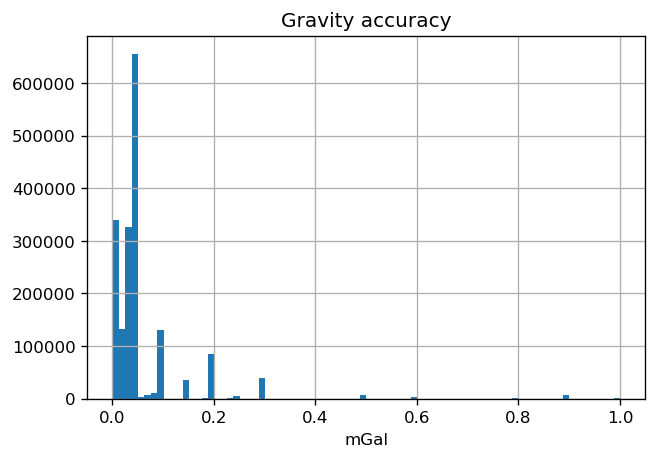

In [5]:
plt.figure()
plt.title("Gravity accuracy")
plt.hist(data.gravity_accuracy.values, bins=80)
plt.xlabel("mGal")
plt.grid()
plt.show()

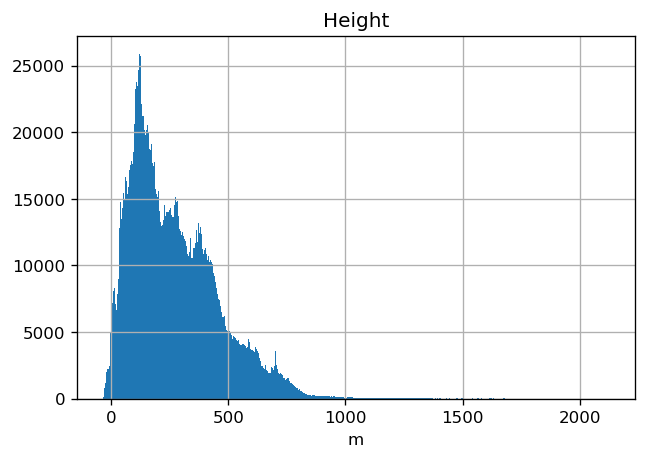

In [6]:
plt.figure()
plt.title("Height")
plt.hist(data.height.values, bins="auto")
plt.xlabel("m")
plt.grid()
plt.show()

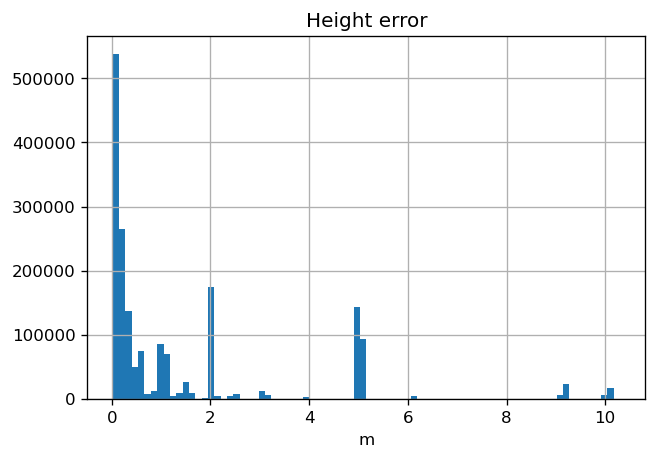

In [7]:
plt.figure()
plt.title("Height error")
plt.hist(data.height_error.values, bins=80)
plt.xlabel("m")
plt.grid()
plt.show()

Some points seem to be below 0m ellipsoid height. This could cause problems for normal gravity calculation (it would be inside the ellipsoid and normal gravity equations are mostly valid outside only).

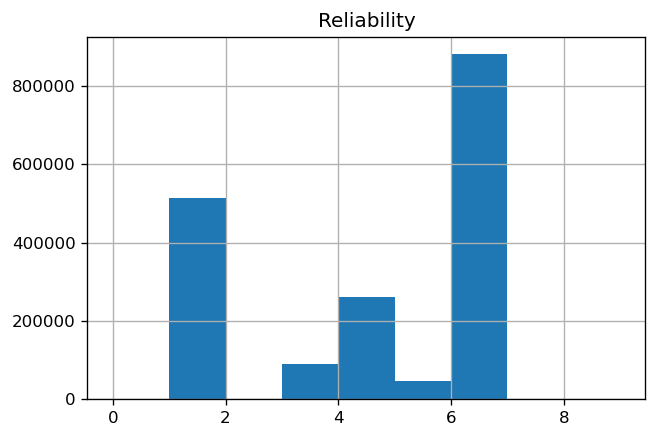

In [8]:
plt.figure()
plt.title("Reliability")
plt.hist(data.reliability_index.values, bins=data.reliability_index.attrs["flag_values"])
plt.grid()
plt.show()

Most points are either 1 (`insufficient_information_to_accurately_classify_but_still_regarded_as_reliable_data`) or 6 (`a_point_occupied_once_with_well_defined_position_and_elevation`) so this is good.

## Maps

Now plot the data points on maps so we can have a sense for the spatial distribution.

First, we'll downsample the data with block mean so that the plotting doesn't take too long.
We'll weight the mean by the data accuracy and return coordinates of the center of each block (instead of the mean coordinates).

In [9]:
blockmean = vd.BlockMean(spacing=0.1, center_coordinates=True, uncertainty=True)

(longitude, latitude), (gravity, height), _ = blockmean.filter(
    coordinates=(data.longitude.values, data.latitude.values),
    data=(data.gravity.values, data.height.values),
    weights=(1/data.gravity_accuracy.values**2, 1/data.height_error.values**2)
)

Let's see how much this reduced the data.

In [10]:
print(f"Downsampled: {gravity.size}")
print(f"Original:    {data.gravity.size}")

Downsampled: 67488
Original:    1789824


Now we can make a map of the reduced data in a reasonable amount of time.

In [11]:
region = [112, 155, -45, -7]

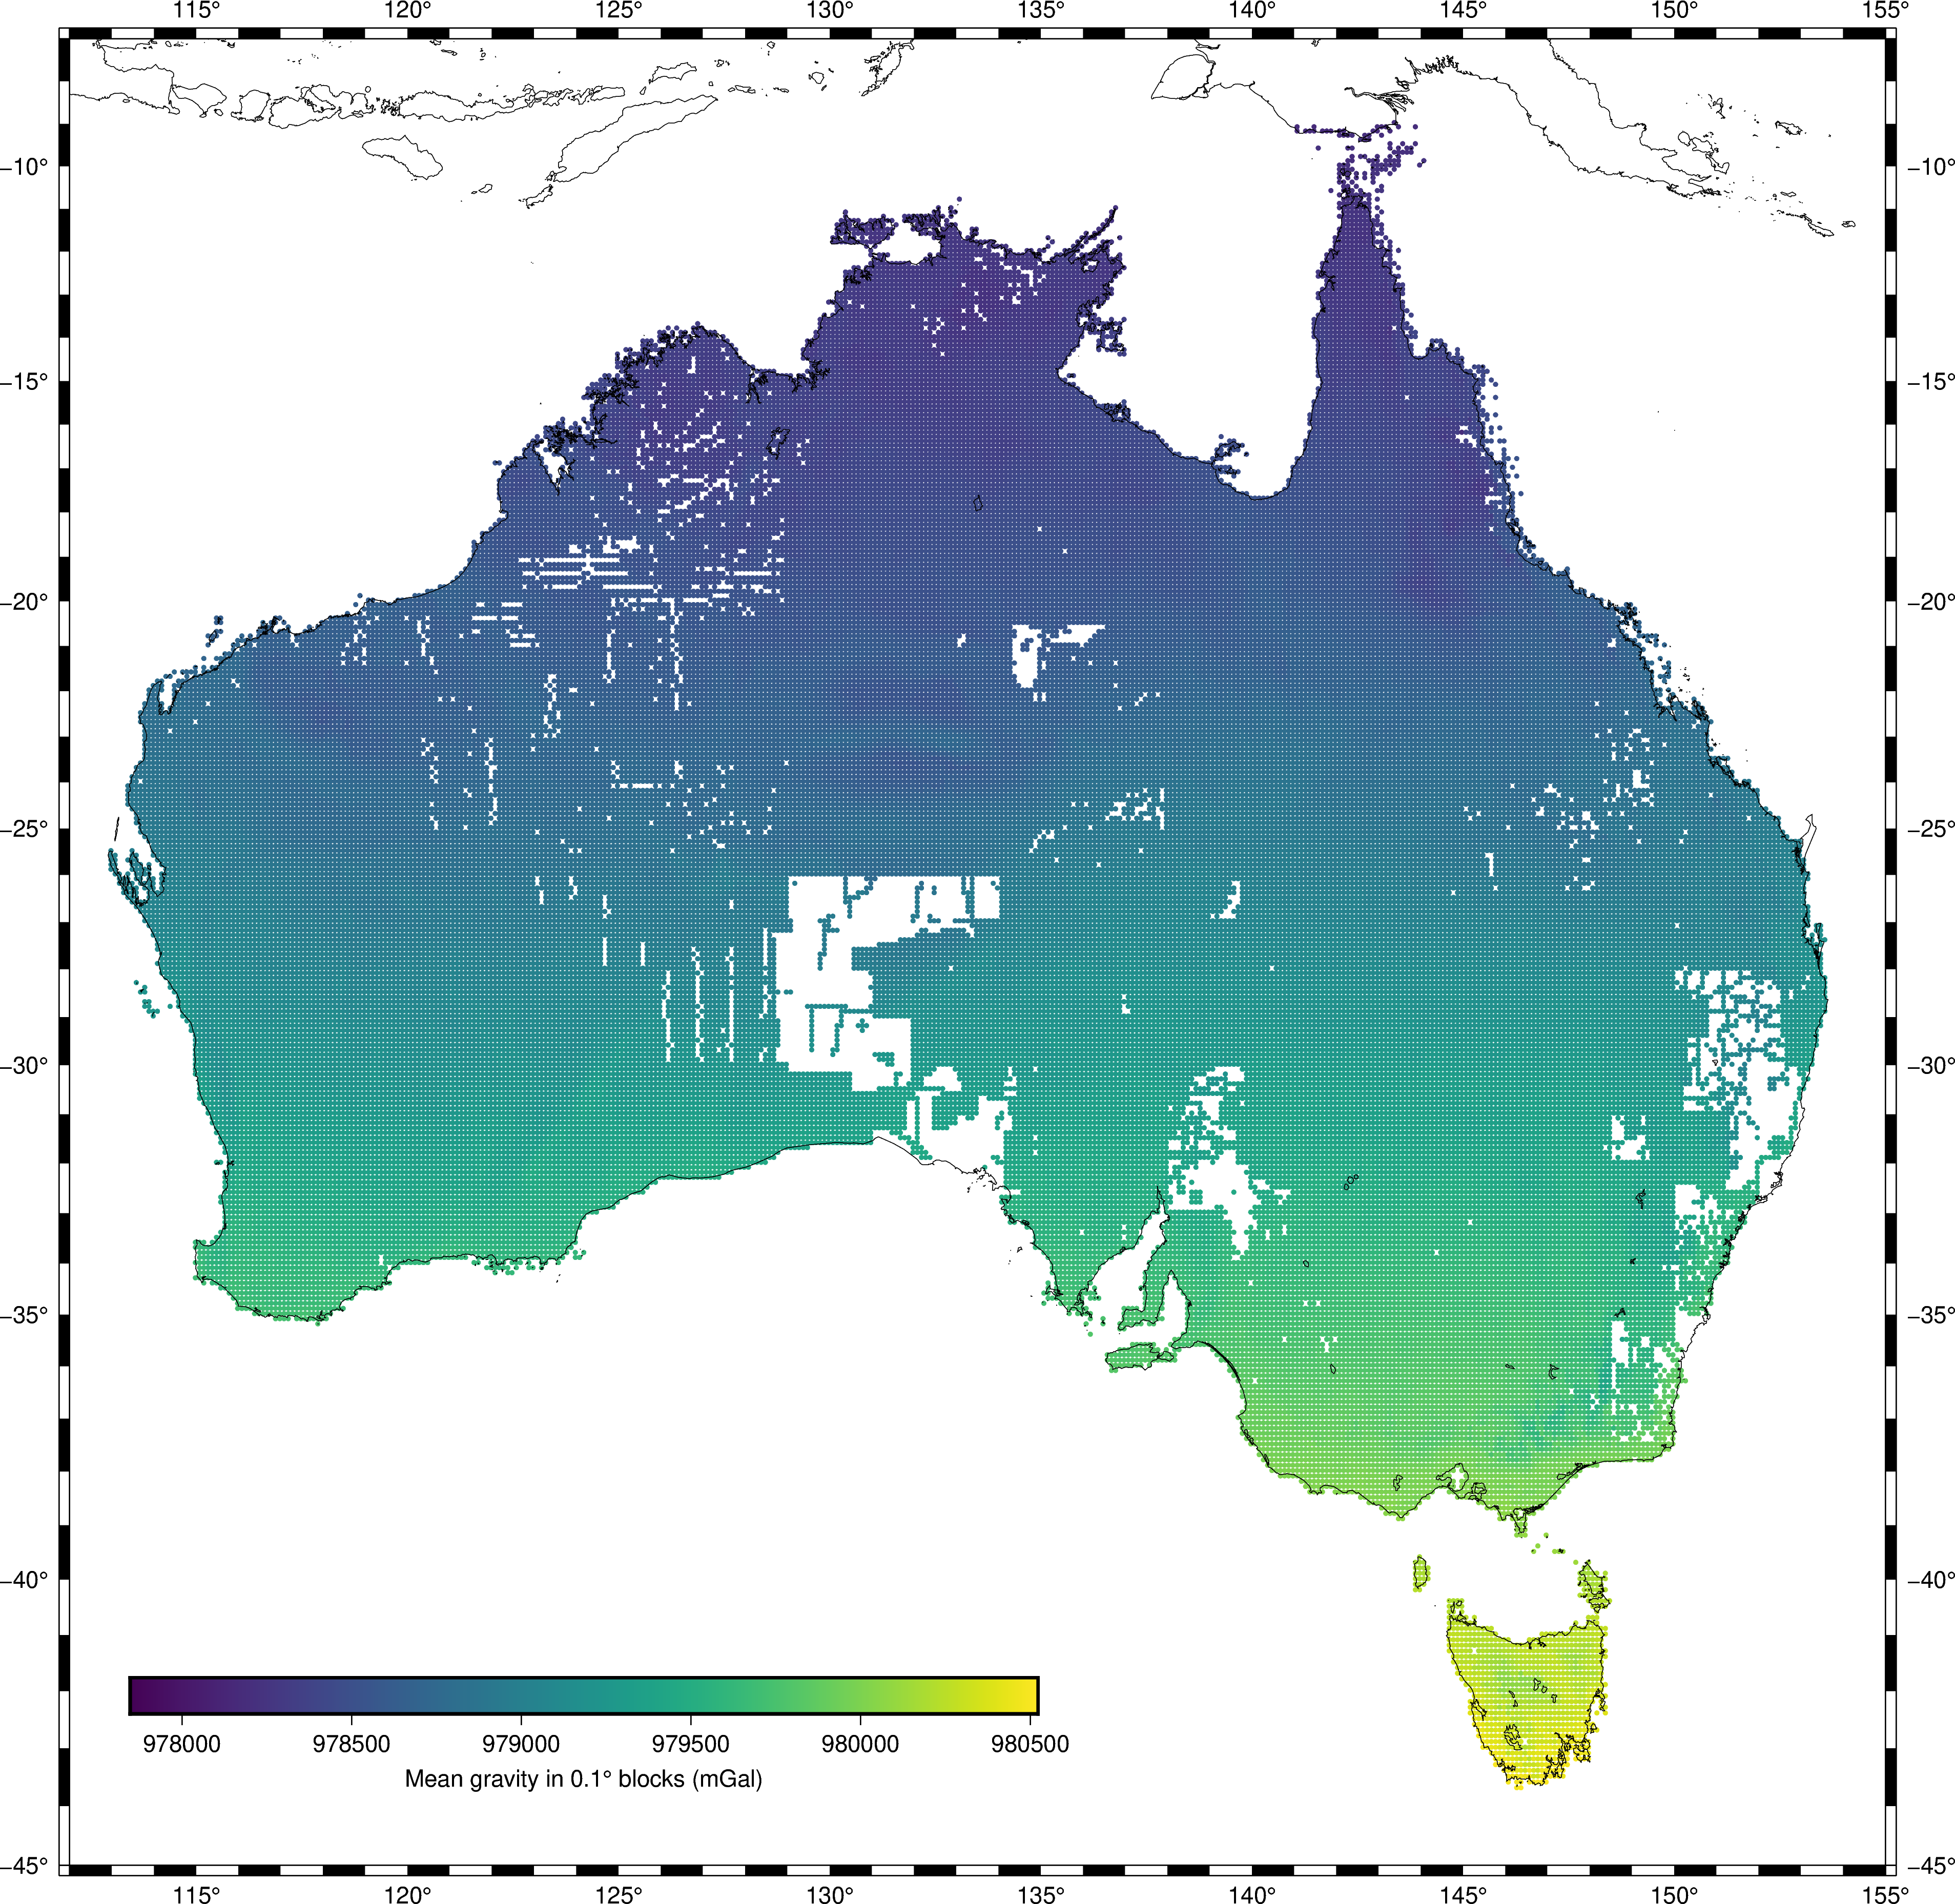

In [12]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M30c", frame="af")
pygmt.makecpt(cmap="viridis", series=data.gravity.actual_range)
fig.plot(longitude, latitude, color=gravity, style="c0.08c", cmap=True)
fig.colorbar(
    position="jBL+h+w15c+o1c/2.5c", 
    frame=f'x500+l"Mean gravity in {blockmean.spacing}\\260 blocks (mGal)"'
)
fig.coast(shorelines=True)
fig.show(width=900)

## Gravity disturbances

Let's calculate gravity disturbances by subtracting the gravity of the WGS84 ellipsoid (using [Boule](https://github.com/fatiando/boule)).
This is only valid if the point is outside the ellipsoid (positive height). 
So we'll have to first filter out the data that falls below.

In [13]:
data_above = data.loc[dict(point=data.height > 0)]
data_above

<xarray.Dataset>
Dimensions:            (point: 1773180)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

In [14]:
normal_gravity = bl.WGS84.normal_gravity(data_above.latitude, data_above.height)
data_above["disturbance"] = data_above.gravity - normal_gravity

Now block reduce the disturbance as well and plot it.

In [15]:
(longitude_above, latitude_above), disturbance, _ = blockmean.filter(
    coordinates=(data_above.longitude.values, data_above.latitude.values),
    data=data_above.disturbance.values,
    weights=1/data_above.gravity_accuracy.values**2
)

/home/leo/miniconda3/envs/australia-gravity/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


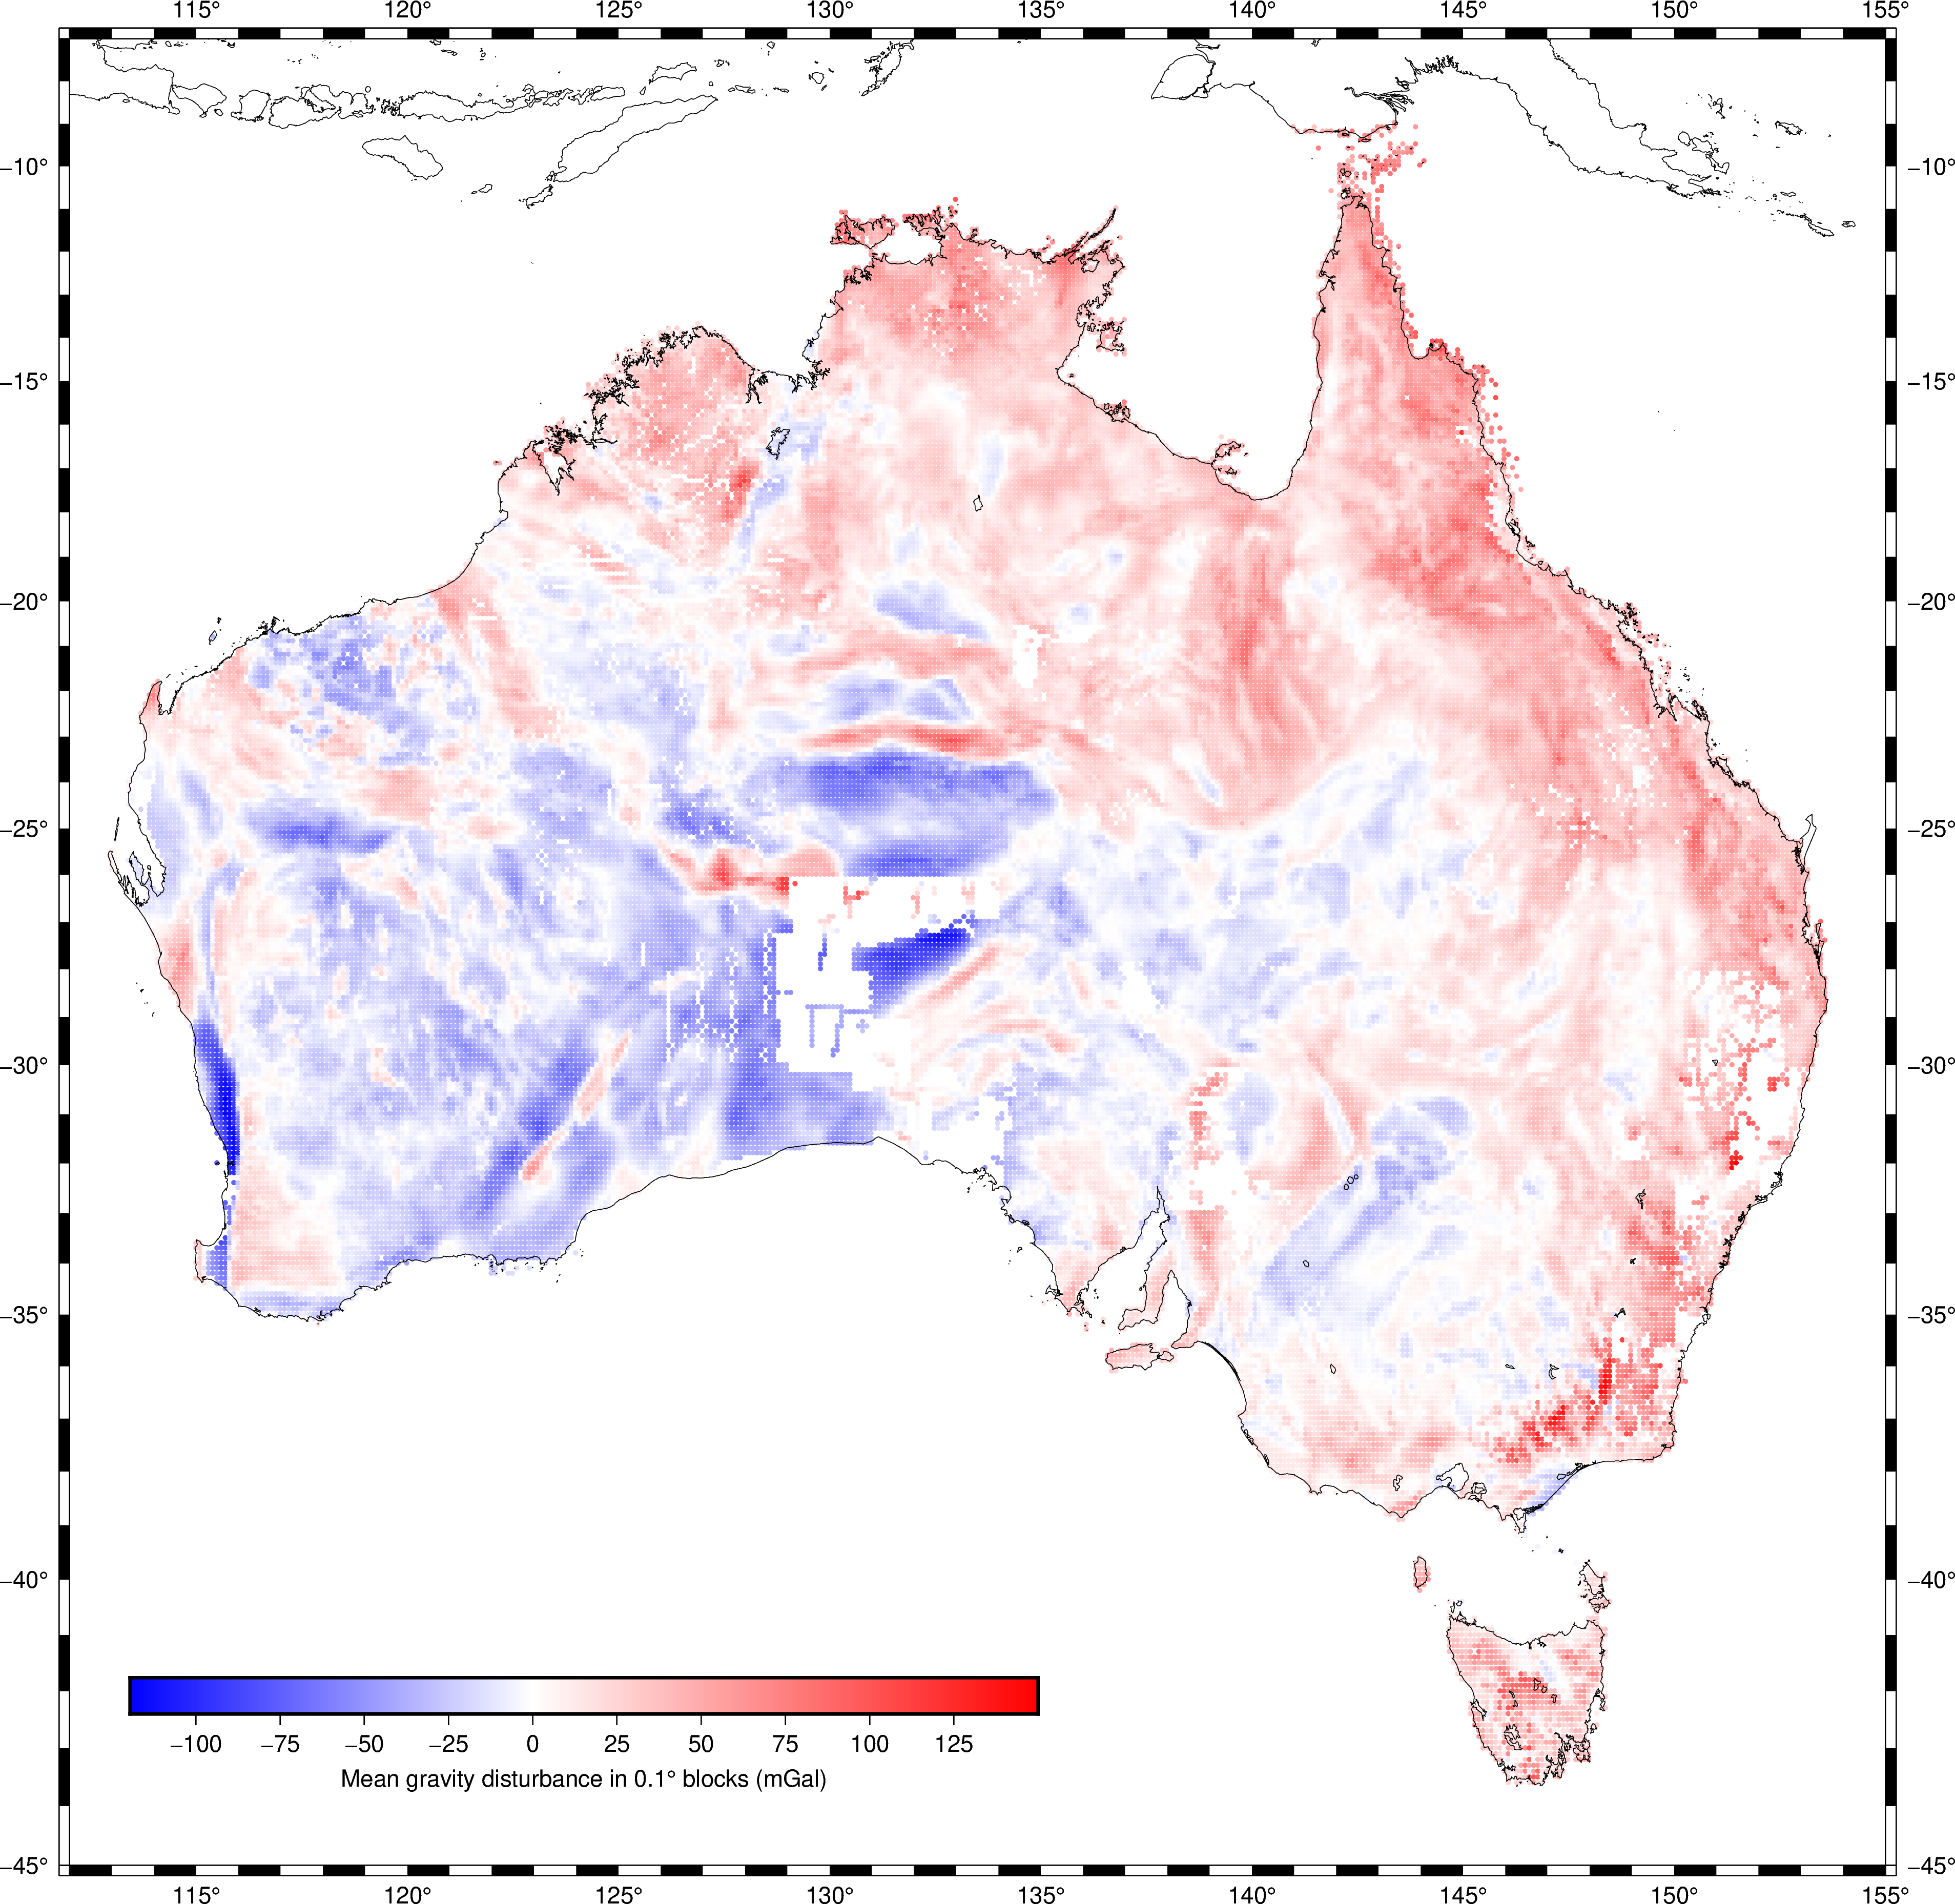

In [16]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M30c", frame="af")
pygmt.makecpt(cmap="polar+h", series=[disturbance.min(), disturbance.max()])
fig.plot(longitude_above, latitude_above, color=disturbance, style="c0.08c", cmap=True)
fig.colorbar(
    position="jBL+h+w15c+o1c/2.5c", 
    frame=f'x25+l"Mean gravity disturbance in {blockmean.spacing}\\260 blocks (mGal)"'
)
fig.coast(shorelines=True)
# Save the figure to show in the README
fig.savefig("../australia-ground-gravity.png", dpi=200)
fig.show(width=900)